# CBF Tutorial
### Authors: 

### In this notebook, we present a short introduction on Control Barrier Functions.

First, let's start by defining a two-dimensional system, called **nimble_ant**, with the following dynamics: 

\begin{align}
  \dot{x} &= \begin{bmatrix}x_0 \\  x_1\end{bmatrix}\\
\end{align}

Given an initial position 
\begin{align*}
x^{init} = \begin{bmatrix} x^{init}_0 \\  x^{init}_1 \end{bmatrix}\\
\end{align*}
our goal is to control this system to a goal location $x^{goal}$. However, the system should avoid certain areas in the workspace (more on this later). 

One way to solve this problem is to pose it as an optimization problem. Specifically, we would like to solve the following problem:
\begin{align*}
\min_{u} \quad & ||u_{ref} - u||\\
\textrm{s.t.} \quad & \text{CBF constraints to be added later}\\
\end{align*}
So, we will try to minimize the distance between the decission variable $u$ and reference controller $u_ref$, while satisfying some constraints. For now, let us disregard the constraint and focus on designing a reference controller. 

### Reference controller

We will define a very simple reference controller as follows
\begin{align*}
u_{ref} = k \times (x^{goal} - x)
\end{align*}
This is a two dimensional vector that takes the difference between the current system state (or location) and the goal location and multiply it with a gain factor $k$. This **simple** reference controller will take us from an initial location to the goal location. Next, we need to make sure that the system does not enter undesired states. 

### Control Barrier Function (CBF) as Constraints

We assume that the undesired regions in the workspace can be defined with one or more ellipses. In two dimensions, the region inside an ellypsis can be using the standard form with the following inequality
\begin{align*}
\frac{z^2_0}{a^2} + \frac{z^2_1}{b^2}\leq 1
\end{align*}
where $z_0,z_1$ define the origin and $a,b$ define the major, minor axes of the ellipse, respectively. 

In our case, we would like to check whether our system is in the undesired region and therefore we modify the afforementined requirement 
\begin{align*}
B(x) = \frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1 
\end{align*}

CBFs are defined by the condition:
\begin{align}
\dot{B}(x) \ge -\alpha(B(x))
\end{align}

Where $\dot{B}(x) = \frac{\partial{B}}{\partial{t}}$ and $\alpha$ is a positive real value. In this example we set $\alpha=1$. $\dot{B}(x)$ indicates how this barrier changes with respect to time. 

In order to calculate $\dot{B}(x)$, we utilize the chain rule, which allows us to write
\begin{align*}
\dot{B}(x) = \frac{\partial{B}}{\partial{x}} \times \frac{\partial{x}}{\partial{t}}
\end{align*}

Since $\frac{\partial{x}}{\partial{t}} = \dot{x}$, then
\begin{align*}
\dot{B}(x) = \frac{\partial{B}}{\partial{x}} \times \dot{x}
\end{align*}
This we can easily solve by taking the derivative of $B(x)$ with respect to $x$
\begin{align*}
\frac{\partial{B}}{\partial{x}} = \begin{bmatrix} \frac{2}{a^2}(x_0 - z_0) \\ \frac{2}{b^2}(x_1 - z_1)\end{bmatrix}
\end{align*}

Plugging this back in the original equation, we get

\begin{align*}
\dot{B}(x) &\ge -\alpha(B(x)) \text{ or}\\
\frac{\partial{B}}{\partial{x}} \dot{x} &\ge -\alpha(B(x)) \text{ or}\\
\begin{bmatrix} \frac{2}{a^2}(x_0 - z_0) \\ \frac{2}{b^2}(x_1 - z_1)\end{bmatrix} \dot{x} &\ge -1*(\frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1)  
\end{align*}

This will be used as a constraint for one ellipse. If there are additional ellipses in the workspace, we can also add more CBFs in a similar fashion.

### Posing the control problem as a quadratic program

We can now combine the cost function with the constraints to form an optimization problem. 

\begin{align*}
\min_{u} \quad & ||u_{ref} - u||\\
\textrm{s.t.} \quad & \begin{bmatrix} \frac{2}{a^2}(x_0 - z_0) \\ \frac{2}{b^2}(x_1 - z_1)\end{bmatrix} \dot{x} &\ge -1*(\frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1) \\
...
\end{align*}

This problem can be posed as a quadratic problem of the form 

\begin{align*}
\min \quad & \frac{1}{2}x^TPx + q^Tx \\
\textrm{s.t.} \quad & Gx \le h \\
\quad & Ax = b
\end{align*}

Where $P = I_2$, the two-dimensional identity matrix and

$$ q = \begin{bmatrix} -u_{ref0} \\  -u_{ref1} \end{bmatrix} $$
$$ G = \begin{bmatrix} \frac{-2}{a^2}(x_0 - z_0) \\ \frac{-2}{b^2}(x_1 - z_1)\end{bmatrix}$$
$$ h = (\frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1) $$

### Code implementation

First, we import the necessary packages for our example. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as control
import cvxopt as cvxopt
from matplotlib.patches import Ellipse
import numpy.random as rnd

Next, we define our controller, which computes the control inputs for the system. We pass several parameters including the goal state and the bad or undesirable sets. We also pass the gain factor for the reference controller. If more than one bad set is provided, the constraintes are added iteratively to the quadratic program.  

In [2]:
def nimble_ant_c(x, params):
    # Controller for silly bug

    goal_x = params['goal_x']
    bad_sets = params['bad_sets']
    ctrl_param = params['ctrl_param']

    # Reference controller
    uref_0 = ctrl_param[0] * ((goal_x[0]-x[0]))
    uref_1 = ctrl_param[1] * ((goal_x[1]-x[1]))

    ############################
    # cvxopt quadratic program
    # minimize  0.5 x'Px + q'x
    # s.t       Gx<=h
    ############################

    # P matrix
    P = cvxopt.matrix(np.eye(2))
    P = .5 * (P + P.T)  # symmetric

    # q matrix
    q = cvxopt.matrix(np.array([-uref_0, -uref_1]), (2, 1))

    # Parameters for the CBF
    G = []
    h = []

    # For each bad set, a separate CBF constraint should be added
    for idxi, _ in enumerate(bad_sets):
        curr_bs = bad_sets[idxi]

        # Elipse: curr_bs = (cx,cy,rad_x,rad_y)
        g1 = 2 * (x[0] - curr_bs[0])/curr_bs[2]**2  # (2*x_0 - cx)/rad_x^2
        g2 = 2 * (x[1] - curr_bs[1])/curr_bs[3]**2  # (2*x_1 - cy)/rad_y^2

        # ((2*x_0 - cx)/rad_x)^2 + ((2*x_1 - cy)/rad_y)^2 - 1
        g3 = ((x[0] - curr_bs[0])/curr_bs[2])**2 + \
            ((x[1] - curr_bs[1])/curr_bs[3])**2 - 1

        G.append([-g1, -g2])
        h.append([g3])

    # Convert lists to cvxopt.matrix object
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)

    # Run optimizer and return solution
    sol = cvxopt.solvers.qp(P, q, G.T, h.T, None, None)
    x_sol = sol['x']
    return x_sol[0:2]

Next, we define the **nimble_ant** system dynamics. The change in the state of the system is computed by the controller. 

In [3]:
def nimble_ant_f(t, x, u, params):
    # Function for a silly bug

    # if goal reached, do nothing
    # goal_x = params['goal_x']
    # if np.linalg.norm(x-goal_x) <= 0.05:
    #     return [0, 0]

    # compute control given current position
    u_0 = nimble_ant_c(x, params)

    # compute change in xy direction
    dx0 = u_0[0]
    dx1 = u_0[1]

    return [dx0, dx1]

We define several helper functions to generate examples. 

In [4]:
def example(i):
    # Examples of different bad sets
    # The x,y,z,d where x,y represent the center and z,d represents the major, minor axes of the ellipse
    switcher = {
        0: [[3., 2., 1., 1.]],
        1: [[1., 2., 0.5, 0.5], [4., 1., 0.5, 0.5],
            [3., 2., 0.5, 0.5], [4.5, 4.2, 0.5, 0.5]],
        2: [[3.5, 1., 0.2, 2.], [2., 2.5, 1., 0.2], [1.5, 1., 0.5, 0.5]],
        3: [[3.5, 3., 0.2, 2.], [2., 2.5, 1., 0.2], [1.5, 1., 0.5, 0.5]]
    }
    return switcher.get(i, "Invalid")

def is_inside_ellipse(x, x_e):
    if ((x[0] - x_e[0])/x_e[2])**2 + ((x[1] - x_e[1])/x_e[3])**2 <= 1:
        return 1
    else:
        return 0

We define the goal for the system, bad sets, and parameters for the controller

In [5]:
# Robot Goal
goal_x = np.array([5, 5])

# Elipse format (x,y,rad_x,rad_y)
bad_sets = example(3)

# Parameters for reference controller
ctrl_param = [0.2, 0.2]

We also define simulation options and define the system using the NonlinearIOSystem class in the control package. 

In [6]:
# Simulation settings
T_max = 20
n_samples = 100
T = np.linspace(0, T_max, n_samples)

# System definition using the control toolbox
silly_bug_sys = control.NonlinearIOSystem(
    nimble_ant_f, None, inputs=None, outputs=None, dt=None,
    states=('x0', 'x1'), name='silly_bug',
    params={'goal_x': goal_x, 'bad_sets': bad_sets, 'ctrl_param': ctrl_param})



Next, we define a grid of initial conditions for the system as follows

In [7]:
# Initial conditions
# min, max of x,y values for initial conditions
min_x, min_y, max_x, max_y = -1, -1, 3, 3
nx, ny = 4, 4              # number of initial conditions in each axis

# Uncomment the following for specific intial conditions
# xx = [0]
# yy = [0]

# Vectors of initial conditions in each axis
xx = np.linspace(min_x, max_x, nx)
yy = np.linspace(min_y, max_y, ny)

We simulate and plot the system. 

Computing trajectories for initial conditions:
x_0	 x_1
-1.0 	 -1.0 	... Done
-1.0 	 0.33 	... Done
-1.0 	 1.67 	... Done
-1.0 	 3.0 	... Done
0.33 	 -1.0 	... Done
0.33 	 0.33 	... Done
0.33 	 1.67 	... Done
0.33 	 3.0 	... Done
1.67 	 -1.0 	... Done
1.67 	 0.33 	... Done
1.67 	 1.67 	... Done
1.67 	 3.0 	... Done
3.0 	 -1.0 	... Done
3.0 	 0.33 	... Done
3.0 	 1.67 	... Done
3.0 	 3.0 	... Done


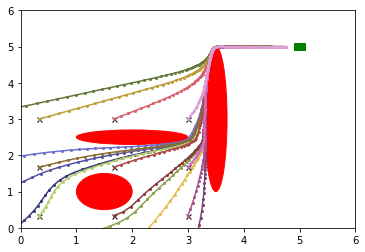

In [8]:
# Disable cvxopt optimiztaion output
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['max_iter'] = 1000


# Plot
fig, ax = plt.subplots()
jet = plt.get_cmap('tab20b')
colors = iter(jet(np.linspace(0, 1, len(xx)*len(yy))))

# Loop through initial conditions
print('Computing trajectories for initial conditions:')
print('x_0\t x_1')
for idxi, i in enumerate(xx):
    for idxk, k in enumerate(yy):
        # If initial condition is inside the bad set, skip it.
        bool_val = 0
        curr_bs = []

        for idxj, j in enumerate(bad_sets):
            curr_bs = bad_sets[idxj]
            if is_inside_ellipse([i, k], bad_sets[idxj]):
                print('Skip (Invalid):\t', i, k)
                bool_val = 1
        if bool_val == 1:
            continue

        print(round(i,2), '\t', round(k,2),"\t... ", end="", flush=True)
        x_0 = np.array([i, k])

        # Compute output on the silly bug system for given initial conditions and timesteps T
        t, y, x = control.input_output_response(sys=silly_bug_sys, T=T, U=0, X0=[
                                                i, k], return_x=True, method='BDF')

        # Plot initial conditions and path of system
        plt.plot(i, k, 'x-', markersize=5, color=[0, 0, 0, 1])
        plt.plot(x[0], x[1], 'o-', markersize=2,
                 color=next(colors, [1, 1, 1, 1]))

        print("Done")

curr_bs = []
for idxi, _ in enumerate(bad_sets):
    curr_bs = bad_sets[idxi]
    ell = Ellipse((curr_bs[0], curr_bs[1]), 2 *
                  curr_bs[2], 2 * curr_bs[3], color='r')
    ax.add_patch(ell)

goal_square = plt.Rectangle(goal_x-np.array([.1, .1]), .2, .2, color='g')
ax.add_patch(goal_square)

plt.xlim(0, 6)
plt.ylim(0, 6)
plt.show()
